In this notebook we will try to create a custom *environment* for an *agent*.

We will have a player, food, enemy. The game is to make player reach food without being caught by the enemy.

In [3]:
import numpy as np # for array manipulation
from PIL import Image # Python Image Library for generating Image of the environment
import cv2 # for image load and resize
import matplotlib.pyplot as plt  # plotting graphs
import pickle # saving and loading the model
from matplotlib import style # make plots pretty
import time # keep track of timestamp

style.use("ggplot")

In [4]:
# CONSTANTS USED

SIZE = 10 # grid size

HM_EPISODES = 25000 # number of episodes to run

MOVE_PENALTY = 1 # penalty for not finding food but keep moving
ENEMY_PENALTY = 300 # caught by enemy punishment
FOOD_REWARD = 25 # reard for reaching food

epsilon = 0.9 # random move - exploration
EPS_DECAY = 0.9998  # Every episode will be epsilon*EPS_DECAY

SHOW_EVERY = 3000  # how often to play through env visually.

# if we have pickled Q-table we can use the same
start_q_table = None # None or Filename

LEARNING_RATE = 0.1 # rate at which the agent learns
DISCOUNT = 0.95 # factor of max future reward to be considered

In [5]:
PLAYER_N = 1  # player key in dict
FOOD_N = 2  # food key in dict
ENEMY_N = 3  # enemy key in dict

# the dict of colours for each element BGR
d = {1: (255, 175, 0), # blue player
     2: (0, 255, 0), # green food
     3: (0, 0, 255)} # red enemy

In [6]:
# Class to get objects of player, food, enemy
class Blob:
    def __init__(self):
        '''
        Initialise the (x,y) co-ordinates of an object.
        '''
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)

    def __str__(self):
        '''
        If we want to print an object.
        '''
        return f"{self.x}, {self.y}"

    def __sub__(self, other):
        '''
        Over-Loaded subtraction, which subtracts and 
        gives relative position of two objects.
        '''
        return (self.x-other.x, self.y-other.y)

    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3).
        These are just diagonal movements. 
        We can also incorporate other movements.
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

    def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y


        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1

In [7]:
if start_q_table is None:
    # initialize the q-table as a dictionary
    # if we don't have a pickled one
    # {(x1,y1),(x2,y2)} --> 4 Q-values for possible action states
    q_table = {}
    # loops over grid size
    for x1 in range(-SIZE+1, SIZE):
        for x2 in range(-SIZE+1, SIZE):
            for y1 in range(-SIZE+1, SIZE):
                    for y2 in range(-SIZE+1, SIZE):
                        q_table[((x1, y1), (x2, y2))] = [np.random.uniform(-5, 0) for i in range(4)]

else:
    # load the pickled Q-Table
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

In [9]:
# list to hold rewards per episode
episode_rewards = []

for episode in range(HM_EPISODES):
    
    # initialise player, food, enemy
    player = Blob()
    food = Blob()
    enemy = Blob()
    
    # whether to show environment or not
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0 # initialise episode reward
    
    for i in range(200):
        # get observation as a relative position from overlaoded subtract
        obs = (player-food, player-enemy)
        
        # explore vs exploit
        if np.random.random() > epsilon:
            # GET THE ACTION
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
        
        # Take the action!
        player.action(action)

        #### MAYBE ###
        #enemy.move()
        #food.move()
        ##############

        # if player and enemy collide
        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        # if food and player meet
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        # keep moving
        else:
            reward = -MOVE_PENALTY
        
        # first we need to obs immediately after the move.
        new_obs = (player-food, player-enemy)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]

        # update Q-values
        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[obs][action] = new_q

        # render the environment
        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
            env[food.x][food.y] = d[FOOD_N]  # sets the food location tile to green color
            env[player.x][player.y] = d[PLAYER_N]  # sets the player tile to blue
            env[enemy.x][enemy.y] = d[ENEMY_N]  # sets the enemy location to red
            img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
            img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
            cv2.imshow("image", np.array(img))  # show it!
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        episode_reward += reward
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break

    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

on #0, epsilon is 0.9


C:\Users\syeda\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\syeda\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3000 ep mean: nan
on #3000, epsilon is 0.49390083359356435
3000 ep mean: -169.154
on #6000, epsilon is 0.27104225936046566
3000 ep mean: -109.382
on #9000, epsilon is 0.14874221981913022
3000 ep mean: -84.88966666666667
on #12000, epsilon is 0.08162656262136181
3000 ep mean: -69.771
on #15000, epsilon is 0.044794919246742226
3000 ep mean: -56.754333333333335
on #18000, epsilon is 0.024582497729691496
3000 ep mean: -47.591
on #21000, epsilon is 0.01349035124500733
3000 ep mean: -42.40833333333333
on #24000, epsilon is 0.0074032174726434705
3000 ep mean: -32.258


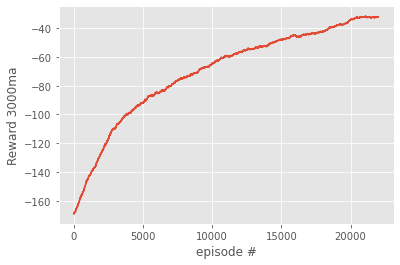

In [10]:
# plot moving average
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

In [11]:
# pickle Q-table
with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)